# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [29]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [30]:
torch.cuda.empty_cache()

In [31]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 
 
Тут я добавил различные аугментации. Для обучающей выборки - это RandomHorizontalFlip, RandomAutocontrast, GaussianBlur и Normalize. А для валидации и теста только Normalize.

In [32]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [33]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [34]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [35]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [36]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

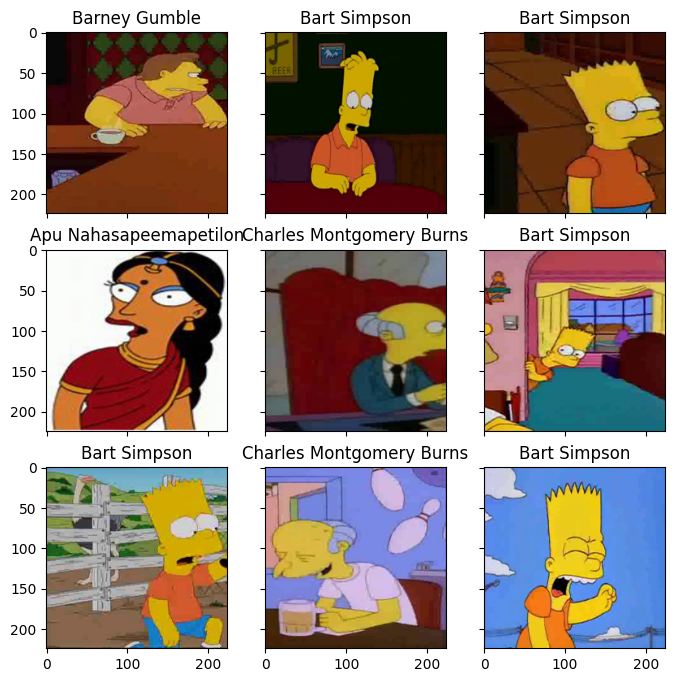

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [38]:
n_classes = len(np.unique(train_val_labels))
print("Кол-во классов :{}".format(n_classes))

Кол-во классов :42


### Построение нейросети

Делать модель с нуля будет весьма труднозатратно и не гарантирует хороший результат, поэтому воспользуемся всемогущим Transfer Learning.


Посмотрим на кол-во обучающих данных и число классов.

In [39]:
n_classes = len(np.unique(train_val_labels))
print("Кол-во классов: {}".format(n_classes))

Кол-во классов: 42


In [40]:
print("Размер обучающей выборки: {}".format(len(train_files)))

Размер обучающей выборки: 15699


Воспользуемся ResNet50, а чтобы все работало корректно, поменяем последний слой.

Данных для обучения больше 10к, но они сильно отличаются от ImageNet. Поэтому попробуем зафайнтюнить всю сеть.

In [41]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

In [42]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [43]:
model.fc = nn.Linear(2048, n_classes)

In [45]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [46]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [47]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            scheduler.step()
            
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [48]:
def predict(model, test_loader):
    with torch.inference_mode():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [49]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

Запустим обучение сети.

In [50]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [51]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6971116789310356


epoch:  10%|█         | 1/10 [14:36<2:11:31, 876.87s/it]


Epoch 001 train_loss: 0.6971     val_loss 0.4354 train_acc 0.8334 val_acc 0.8926
loss 0.20921628262022587


epoch:  20%|██        | 2/10 [28:13<1:52:09, 841.22s/it]


Epoch 002 train_loss: 0.2092     val_loss 0.3224 train_acc 0.9459 val_acc 0.9207
loss 0.13928063367497306


epoch:  30%|███       | 3/10 [43:17<1:41:31, 870.15s/it]


Epoch 003 train_loss: 0.1393     val_loss 0.2920 train_acc 0.9650 val_acc 0.9192
loss 0.10613771373289423


epoch:  40%|████      | 4/10 [56:44<1:24:29, 844.97s/it]


Epoch 004 train_loss: 0.1061     val_loss 0.3291 train_acc 0.9703 val_acc 0.9177
loss 0.04585420960516898


epoch:  50%|█████     | 5/10 [1:11:42<1:12:02, 864.40s/it]


Epoch 005 train_loss: 0.0459     val_loss 0.1216 train_acc 0.9886 val_acc 0.9744
loss 0.01921043295685077


epoch:  60%|██████    | 6/10 [1:28:02<1:00:14, 903.60s/it]


Epoch 006 train_loss: 0.0192     val_loss 0.1144 train_acc 0.9961 val_acc 0.9759
loss 0.013570622971759677


epoch:  70%|███████   | 7/10 [1:43:22<45:26, 908.86s/it]  


Epoch 007 train_loss: 0.0136     val_loss 0.1104 train_acc 0.9969 val_acc 0.9784
loss 0.008129164791074573


epoch:  80%|████████  | 8/10 [1:57:32<29:40, 890.25s/it]


Epoch 008 train_loss: 0.0081     val_loss 0.1099 train_acc 0.9984 val_acc 0.9784
loss 0.006658227461568109


epoch:  90%|█████████ | 9/10 [2:11:52<14:40, 880.75s/it]


Epoch 009 train_loss: 0.0067     val_loss 0.1108 train_acc 0.9989 val_acc 0.9778
loss 0.005502706001551504


epoch: 100%|██████████| 10/10 [2:20:53<00:00, 845.38s/it]


Epoch 010 train_loss: 0.0055     val_loss 0.1103 train_acc 0.9992 val_acc 0.9786


Построим кривые обучения

In [52]:
loss, acc, val_loss, val_acc = zip(*history)

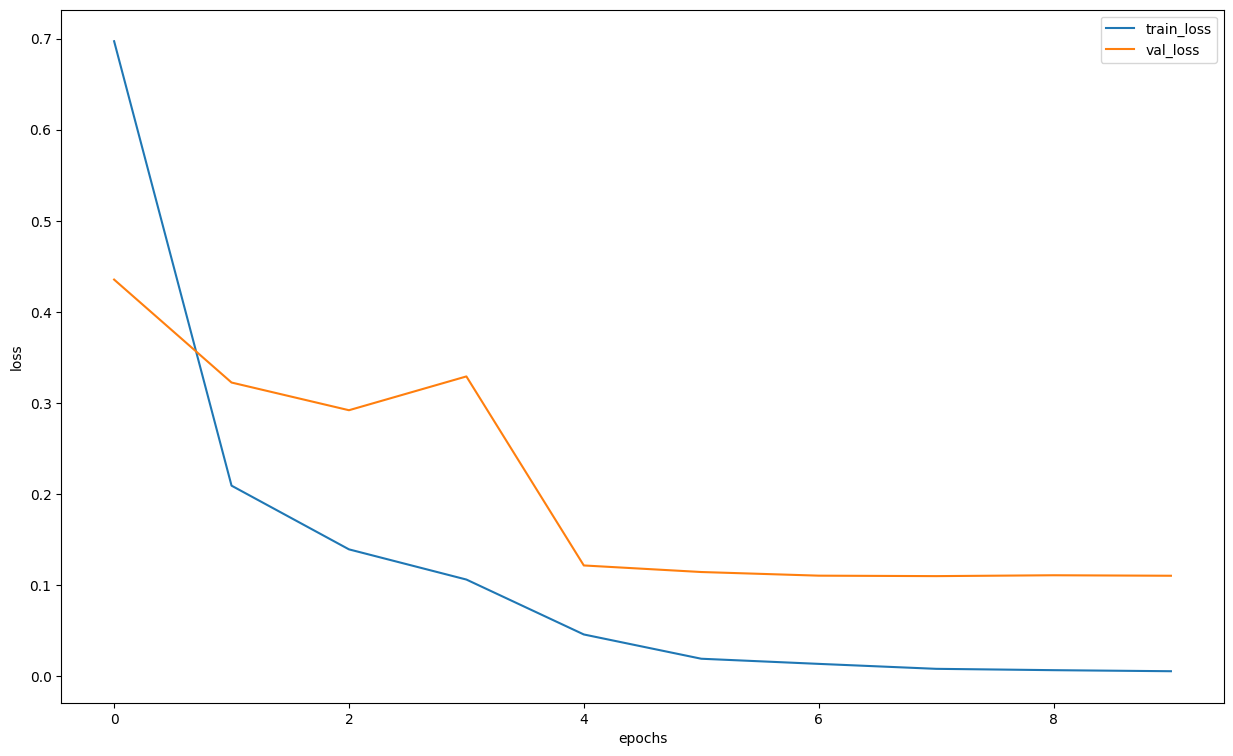

In [53]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [54]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.inference_mode():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [55]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [56]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [57]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [58]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, xkcd script, fantasy
findfont: Generic family 'fantasy' not found because none of the following familie

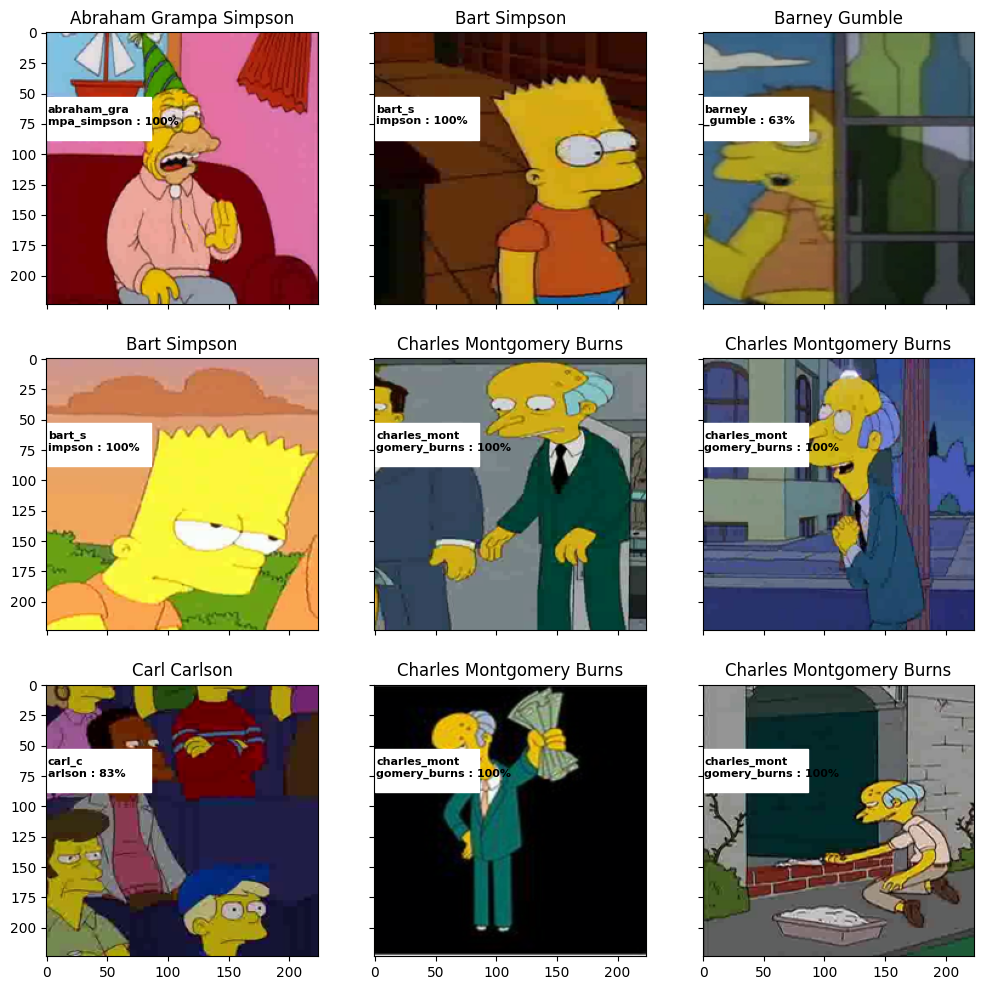

In [60]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [61]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [32]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [33]:
my_submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [34]:
my_submission.to_csv('/kaggle/working/my_submission.csv', index=False)

**Score: 0.99362**